In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os.path
import glob
import pandas as pd

### Measure error rate (single pair)

In [3]:
def getSheetRefLocs(scoreid, striplens):
    
    # get annotation file
    annot_dir = 'annot_sheet'
    piece = scoreid.split('_')[0]
    annot_file_beats = '%s/%s_beats.csv' % (annot_dir, piece)
    df_all = pd.read_csv(annot_file_beats)
    
    # calculate global pixel position
    df = df_all.loc[df_all.score == scoreid]
    pixelOffset = np.cumsum([0] + striplens)  # cumulative pixel offset for each strip
    stripsPerPage = [df.loc[df.page == i,'strip'].max() for i in range(df.page.max()+1) ]
    stripOffset = np.cumsum([0] + stripsPerPage)
    stripIdx = stripOffset[df.page] + df.strip - 1  # cumulative strip index
    hpixlocs = pixelOffset[stripIdx] + df.hpixel
    
    return hpixlocs.values

In [4]:
def getMidiRefLocs(midiID, scoreID, fs, zeroPad, timeMapping):
    
    # get annotation file
    annot_dir = 'annot_audio'
    piece = scoreID.split('_')[0]
    parts = midiID.split('-') # e.g. pid1263b-19-avgtapsd0
    annot_file = '%s/%s/%s-%s-avgtap-sv.txt' % (annot_dir, piece, parts[0], parts[1])
    df = pd.read_csv(annot_file, header=None, sep='\t', comment='#')
    
    # convert to mapped frames
    timeStamps = df.loc[:,0].values
    beatLabels = df.loc[:,1].values
    frames = (timeStamps - timeStamps[0]) * fs
    mapped_frms = [i for i, elem in enumerate(timeMapping) if elem != -1]
    orig_frms = [elem for elem in timeMapping if elem != -1]
    mapped_interp = np.interp(frames, orig_frms, mapped_frms)
    padded = mapped_interp + zeroPad
    
    return padded

In [6]:
def calcPredErrors(hyp_file, predType):
    
    # load hypothesis data
    with open(hyp_file, 'rb') as f:
        dhyp = pickle.load(f)
    fs = dhyp['fs']
    zeroPad = dhyp['zeroPad']
    timeMapping = dhyp['timeMapping']
    striplens = dhyp['striplens']
    wp = dhyp['wp']
    
    # get ground truth annotations
    basename = os.path.splitext(os.path.basename(hyp_file))[0] # e.g. op68no3_v1--pid1263b-19-avgtapsd0.pkl
    (scoreID, midiID) = basename.split('--')
    sheet_ref_beats = getSheetRefLocs(scoreID, striplens)    
    midi_ref_beats = getMidiRefLocs(midiID, scoreID, fs, zeroPad, timeMapping)

    # get beat predictions
    if predType == 'wp':
        sheet_preds = wp[:,0]
        midi_preds = wp[:,1]
    elif predType == 'globallinear':
        sheet_preds = wp[[0,-1],0]
        midi_preds = wp[[0,-1],1]
    elif predType == 'oracle':
        if len(sheet_ref_beats) % 3 == 0: 
            offset = 0 # first beat is downbeat
        else:
            offset = 1 # first beat is pickup
        downbeat_idxs = np.arange(offset, np.min((len(sheet_ref_beats), len(midi_ref_beats))), 3)
        sheet_preds = sheet_ref_beats[downbeat_idxs]
        midi_preds = midi_ref_beats[downbeat_idxs]
    else:
        print('Unrecognized prediction type: %s' % predType)
        sys.exit(1)
        
    # calculate prediction errors
    hypFrames = np.interp(sheet_ref_beats, sheet_preds, midi_preds)
    hypPixels = np.interp(midi_ref_beats, midi_preds, sheet_preds)
    minLen = np.min((len(hypFrames), len(hypPixels)))
    errsFrames = hypFrames[0:minLen] - midi_ref_beats[0:minLen]
    errsTime = errsFrames * 1000.0 / fs  # in ms
    errsPixels = hypPixels[0:minLen] - sheet_ref_beats[0:minLen]        
        
    return errsTime, errsPixels, midi_ref_beats, sheet_ref_beats

In [7]:
def calcErrorStats(errs_raw, tols, isSingle = False):
    if isSingle:
        errs = errs_raw
    else:
        errs = np.array([err for sublist in errs_raw for err in sublist])
    errs = errs[~np.isnan(errs)] # when beat is not annotated, value is nan
    errorRates = []
    for tol in tols:
        toAdd = np.sum(np.abs(errs) > tol) * 1.0 / len(errs)
        errorRates.append(toAdd)
    return errorRates

In [8]:
def calcErrorStats_globalLinear(errs_raw, tols):
    
    # accumulate only the non-downbeat predictions
    errs = []
    for sublist in errs_raw:
        sum1 = np.nansum(np.abs(sublist[0::3]))
        sum2 = np.nansum(np.abs(sublist[1::3]))
        sum3 = np.nansum(np.abs(sublist[2::3]))
        minMod = np.argmin([sum1, sum2, sum3])
        toAdd = [e for i, e in enumerate(sublist) if i % 3 != minMod]
        errs.extend(toAdd)
    
    # score as before
    errs = np.array(errs)
    errs = errs[~np.isnan(errs)] # when beat is not annotated, value is nan
    errorRates = []
    for tol in tols:
        toAdd = np.sum(np.abs(errs) > tol) * 1.0 / len(errs)
        errorRates.append(toAdd)
    return errorRates

In [9]:
def plotErrorRateSingle(hyp_file, title = None):

    # calculate error rates
    errsTime, errsPixels, _, _ = calcPredErrors(hyp_file, 'wp')
    tols_ms = range(3000)
    tols_px = range(200)
    pixelErrorRates = calcErrorStats(errsPixels, tols_px, isSingle = True)
    timeErrorRates = calcErrorStats(errsTime, tols_ms, isSingle = True)

    # plot error curves
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(tols_ms, 100.0*np.array(timeErrorRates))
    plt.ylim((0,100))
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.subplot(122)
    plt.plot(tols_px, 100.0*np.array(pixelErrorRates))
    plt.ylim((0,100))
    plt.xlabel('Error Tolerance (pixels)')
    plt.ylabel('Error Rate (%)')
    if title:
        plt.title(title)
    plt.show()

Look at a random sample of files to investigate problems

In [10]:
hyp_files = glob.glob('hyp_align/*.pkl')
np.random.shuffle(hyp_files)
for i, hyp_file in enumerate(hyp_files):
    plotErrorRateSingle(hyp_file, os.path.basename(hyp_file))
    if i == 20:
        break

### Measure error rate (all pairs)

In [11]:
def calcAllErrors(hyp_dir, predType):    
    
    hyp_files = sorted(glob.glob('%s/*.pkl' % hyp_dir))
    hyp_files = [f for f in hyp_files if 'pid9140-05' not in f] # omit files with structural differences
    time_errs = []
    pixel_errs = []
    debug = {}
    
    for hyp_file in hyp_files: # e.g. 'hyp_align/op68no3_v1--pid1263b-19-avgtapsd0.pkl'

        # calc errors
        errs_t, errs_l, midi_ref, sheet_ref = calcPredErrors(hyp_file, predType)
        time_errs.append(errs_t)
        pixel_errs.append(errs_l)
        
        # save debug info
        basename = os.path.splitext(os.path.basename(hyp_file))[0]
        scoreId = basename.split('--')[0]
        debug[scoreId] = sheet_ref
        debug[basename] = midi_ref
    
    with open('gt.pkl', 'wb') as f:
        pickle.dump(debug, f)
        
    return time_errs, pixel_errs, hyp_files

In [12]:
time_errs_bs, pixel_errs_bs, hyp_files = calcAllErrors('hyp_align', 'wp') # bootleg synthesis
time_errs_b1, pixel_errs_b1, _ = calcAllErrors('hyp_align', 'globallinear') # baseline 1
time_errs_b2, pixel_errs_b2, _ = calcAllErrors('hyp_align', 'oracle') # baseline 2

### Plot error curves

In [13]:
def getPrunedErrors(errs, hyp_files):
    errs_pruned = [l for i, l in enumerate(errs) if '_v4' not in hyp_files[i]] # omits poor quality sheet images 
    return errs_pruned

In [15]:
def calcAvgBeatLength_px():
    with open('gt.pkl','rb') as f:
        d = pickle.load(f)
    accum = 0
    cnt = 0
    for key in d:
        if '--' not in d:
            beats = d[key]
            diff = beats[1:] - beats[0:-1]
            accum += np.nansum(diff)
            cnt += len(diff) - np.sum(np.isnan(diff))
    print('Avg beat length: %.1f pixels' % (accum_p*1.0/cnt_p))

In [17]:
def calcAvgBeatLength_ms():
    annotfiles = glob.glob('annot_audio/*/*.txt')
    accum = 0
    cnt = 0
    for annotfile in annotfiles:
        df = pd.read_csv(annot_file, header=None, sep='\t', comment='#')
        beats = df.loc[:,0].values
        diff = beats[1:] - beats[0:-1]
        accum += np.sum(diff)
        cnt += len(diff)
    print('Avg beat length: %.3f ms' % (accum * 1000.0 / cnt))

In [18]:
tols_px = range(51)
tols_ms = range(501)

# baseline 1
timeErrorRates_b1 = calcErrorStats(time_errs_b1, tols_ms)
pixelErrorRates_b1 = calcErrorStats(pixel_errs_b1, tols_px)

# baseline 2
timeErrorRates_b2 = calcErrorStats_globalLinear(time_errs_b2, tols_ms)
pixelErrorRates_b2 = calcErrorStats_globalLinear(pixel_errs_b2, tols_px)

# bootleg synthesis
timeErrorRates_bs = calcErrorStats(time_errs_bs, tols_ms)
pixelErrorRates_bs = calcErrorStats(pixel_errs_bs, tols_px)

# bootleg synthesis (excludes poor quality scans)
time_errs_bs_pruned = getPrunedErrors(time_errs_bs, hyp_files)
pixel_errs_bs_pruned = getPrunedErrors(pixel_errs_bs, hyp_files)
timeErrorRates_bs_pruned = calcErrorStats(time_errs_bs_pruned, tols_ms)
pixelErrorRates_bs_pruned = calcErrorStats(pixel_errs_bs_pruned, tols_px)

Frame error curves

In [19]:
calcAvgBeatLength_ms()

NameError: name 'annot_file' is not defined

FileNotFoundError: [Errno 2] No such file or directory: 'figs/error_curves_ms.png'

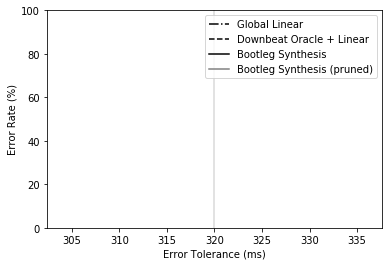

In [20]:
plt.axvline(x=320, color = '.85')
plt.plot(tols_ms, 100.0*np.array(timeErrorRates_b1), 'k-.', label='Global Linear')
plt.plot(tols_ms, 100.0*np.array(timeErrorRates_b2), 'k--', label='Downbeat Oracle + Linear')
plt.plot(tols_ms, 100.0*np.array(timeErrorRates_bs), 'k-', label='Bootleg Synthesis')
plt.plot(tols_ms, 100.0*np.array(timeErrorRates_bs_pruned), '.5', label='Bootleg Synthesis (pruned)')
plt.ylim((0,100))
plt.xlabel('Error Tolerance (ms)')
plt.ylabel('Error Rate (%)')
plt.legend()
plt.savefig('figs/error_curves_ms.png', dpi=300, bbox_inches = 'tight')
plt.show()

Pixel error curves

In [ ]:
calcAvgBeatLength_px()

In [ ]:
plt.axvline(x=30, color = '.85')
plt.plot(tols_px, 100.0*np.array(pixelErrorRates_b1), 'k-.', label='Global Linear')
plt.plot(tols_px, 100.0*np.array(pixelErrorRates_b2), 'k--', label='Downbeat Oracle + Linear')
plt.plot(tols_px, 100.0*np.array(pixelErrorRates_bs), 'k-', label='Bootleg Synthesis')
plt.plot(tols_px, 100.0*np.array(pixelErrorRates_bs_pruned), '.5', label='Bootleg Synthesis (pruned)')
plt.ylim((0,100))
plt.xlabel('Error Tolerance (pixels)')
plt.ylabel('Error Rate (%)')
plt.legend()
plt.savefig('figs/error_curves_px.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
tol = 500
timeErrorRates_b1[tol], timeErrorRates_b2[tol], timeErrorRates_bs[tol], timeErrorRates_bs_pruned[tol]

In [ ]:
tol = 7
pixelErrorRates_b1[tol], pixelErrorRates_b2[tol], pixelErrorRates_bs[tol], pixelErrorRates_bs_pruned[tol]